# E10 뉴스기사 요약해보기 📜
---


### 루브릭

|평가문항|	상세기준|
|:-------|:---------|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.| 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|


## Table of Contents
1. [데이터 수집하기](#load)
2. [데이터 전처리하기 (추상적 요약)](#preprocess)
3. [어텐션 메커니즘 사용하기 (추상적 요약)](#attention)
4. [실제 결과와 요약문 비교하기(추상적 요약)](#result)
5. [Summa을 이용해서 추출적 요약해보기](#extrative)
6. [프로젝트 요약](#summary)

<a name="load"></a>
### 1. 데이터 수집하기
---


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.


||Abstractive 요약| Extractive 요약|
|:------|:-------------:|:--------------:|
|text| 사용 O | 사용 O|
| headlines | 사용 O | 사용 X|

In [1]:
import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

<a name="preprocess"></a>
### 2. 데이터 전처리하기 (추상적 요약)
---

- 중복 샘플과 NULL 값이 존재하는 샘플 제거
- 정규화 사전, 불용어 사전
- preprocess_sentence
    1. 텍스트 소문자화
    2. html 태그제거
    3. 괄호로 닫힌 문자열 제거
    4. 쌍따옴표 제거
    5. 텍스트 정규화
    6. 소유격 제거
    7. 영어 외 문자(숫자, 특수문자) 공백으로 변환
    8. m이 3개 이상이면 2개로 변경 
    9. 불용어제거(불용어 제거는 text 전처리 시에만 호출, headlines는 상대적으로 문장 길이가 짧음)
- 멀티프로세싱
- 샘플의 최대개수 정하기
- 시작 토큰과 종료 토큰 추가하기
- 훈련, 테스트 테이터 분리
- 정수 인코딩

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
print('전체 샘플 수:', len(data))

전체 샘플 수: 98401


In [4]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


#### 2.1 중복 샘플과 NULL 값이 존재하는 샘플 제거
---

In [ ]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

In [6]:
# text 중복 샘플 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
# Null Check
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


#### 2.2 정규화 사전
---

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 2.3 불용어 사전
---

In [ ]:
# 불용어
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

#### 2.4 preprocess_sentence
---

In [11]:
# 불용어 제거는 text 전처리 시에만 호출, headlines는 상대적으로 문장 길이가 짧음
# Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Headlines에 남아 있는 게 더 좋을 것 같습니다.
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


#### 2.5 멀티프로세싱
---

In [13]:
import time

def process_data(df, col):
    result = []
    
    start_time = time.time()
    for s in df[col]:
        result.append(preprocess_sentence(s))
    print("{} : {} seconds".format(col, time.time() - start_time))
    return result

In [14]:
#text : 735.3365228176117 seconds
#headlines : 149.51734685897827 seconds
#clean_text = process_data(data, 'text')
#clean_headlines = process_data(data, 'headlines')

In [15]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(df, col, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data[col], num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print("{} : {} seconds".format(col, time.time() - start_time))
    return processed_data

clean_text = preprocess_data(data,'text')  # 클라우드 기준으로 3~4분 정도 소요 됩니다

clean_headlines = preprocess_data(data, 'headlines', remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.

text : 184.11262106895447 seconds
headlines : 6.173166275024414 seconds


텍스트 정제의 과정을 거친 후에는 다시 한번 **빈(empty) 샘플**이 생겼는지 확인해보는 것이 좋아요.
정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요. 이렇게 되
면 샘플 자체가 빈 값을 가지게 되겠죠.

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [18]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [19]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### 2.6 샘플의 최대 길이 정하기
---
필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


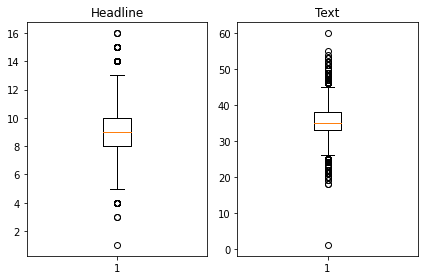

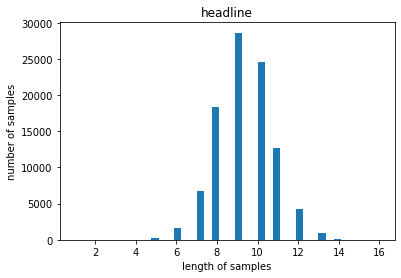

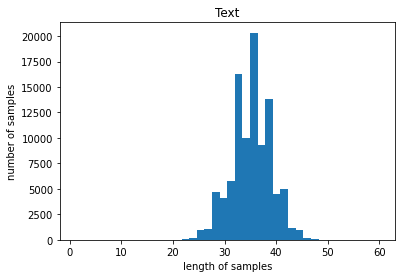

In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('Headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
# 그래프의 분포를 보고 임의로 숫자를 정했다.
text_max_len = 40
headline_max_len = 11

In [22]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [23]:
print('text')
below_threshold_len(text_max_len, data['text'])
print('--------------------------------------------------------------')
print('headline')
below_threshold_len(headline_max_len,  data['headlines'])

text
전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
--------------------------------------------------------------
headline
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [24]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


#### 2.7 시작 토큰과 종료 토큰 추가하기
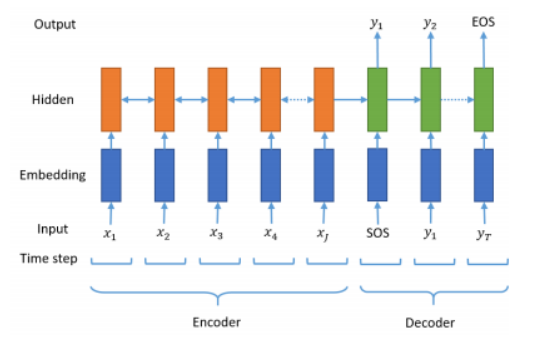


|seq2seq | decoder_input(입력) | decoder_target(출력, 레이블) |
|:-----:|:-----------:|:-------:|
|시작토큰| \<sostoken> + ~||
|종료토큰| |~ + \<eostoken>| 


In [25]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [ ]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### 2.8 훈련 데이터와 테스트 데이터 분리
---
np.random.shuffle을 사용하여 섞인 데이터를 8:2 비율로 훈련 데이터와 테스트 데이터로 분리한다.

In [27]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[20469  5389 67141 ... 49912 10558 19810]


In [28]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [29]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [30]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


#### 2.9 정수 인코딩
---

1. Tokenizer()
    - 텍스트를 토큰화
2. fit_on_texts()
    - 입력 데이터로부터 단어 집합 생성, 각 단어에 고유한 정수가 부여
3. word_index
    - 생성된 단어 집합
4. word_counts
    - 각 단어와 그 단어의 등장 빈도수가 저장되어있는 딕셔너리
5. texts_to_sequences()
    - 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다.

In [34]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [35]:
# 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64746
등장 빈도가 6번 이하인 희귀 단어의 수: 44135
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20611
단어 집합에서 희귀 단어의 비율: 68.16637321224476
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.768393862999005


In [36]:
# 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기는 20611이다.
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [37]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[13, 1833, 1032, 8517, 5661, 349, 95, 149, 1399, 350, 2744, 582, 734, 637, 3851, 626, 287, 1879, 95, 83, 450, 787, 1918, 5661, 349, 131, 1251, 2254, 1897, 5344, 18008, 937, 3087, 1339, 2744, 734, 637, 1020], [4257, 2, 14, 1224, 2255, 74, 446, 192, 25, 879, 174, 2377, 7, 1, 4257, 766, 5229, 8677, 1828, 1390, 500, 8353, 446, 823, 444, 325, 534, 7, 4, 3852, 8193, 158, 1716, 3950], [46, 197, 2144, 5, 42, 749, 2210, 563, 1149, 5345, 148, 11844, 122, 1471, 1758, 1171, 749, 4223, 441, 5536, 1078, 3714, 1467, 833, 461, 2210, 3038, 1375, 769]]


In [38]:
# 헤드라인 데이터에도 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28493
등장 빈도가 5번 이하인 희귀 단어의 수: 18757
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9736
단어 집합에서 희귀 단어의 비율: 65.8302039097322
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.15421815300592


In [39]:
# 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9736
tar_vocab = 9700
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input ',decoder_input_train[:5])
print('decoder ',decoder_target_train[:5])

input  [[1, 28, 833, 1661, 276, 13, 1195, 3, 2614, 5, 4, 1424], [1, 76, 31, 750, 87, 115, 11, 8172, 4, 93, 3327], [1, 124, 2858, 6, 529, 4426, 784, 1239, 921, 131], [1, 7603, 8887, 562, 13, 2502, 99], [1, 388, 2399, 3, 6659, 8, 2503, 5146, 5]]
decoder  [[28, 833, 1661, 276, 13, 1195, 3, 2614, 5, 4, 1424, 2], [76, 31, 750, 87, 115, 11, 8172, 4, 93, 3327, 2], [124, 2858, 6, 529, 4426, 784, 1239, 921, 131, 2], [7603, 8887, 562, 13, 2502, 99, 2], [388, 2399, 3, 6659, 8, 2503, 5146, 5, 2]]


In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68674
훈련 레이블의 개수 : 68674
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [41]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

<a name="attention"></a>
## 3. 어텐션 메커니즘 사용하기 (추상적 요약)
---
1. Encoder 설계
2. Decoder 설계 
3. Attention 적용
4. 인퍼런스 모델

### 3.1 Encoder 설계
---
#### INPUT
  >text_max_len = 40
    
    
#### Embedding
   >src_vocab = 20000, embedding_dim = 128


**LSTM**

##### hidden_state :  LSTM에서 얼만큼의 수용력(Capacity)를 가질지를 정하는 파라미터
- 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수 다른 신경망과 마찬가지로 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가지는 않는다.

##### return_sequences : 시퀀스 출력 여부
-  return_sequences = True로 설정할 경우 각 time step별 hidden state를 모두 출력하게 된다. Attention을 사용할 때 주로 설정한다.

##### return_state : 시퀀스 출력 여부
-  return_state = True 를 한 경우에는 마지막 time step에서의 output(hidden state), hidden state와 cell state가 출력된다



##### dropout 
- 0과 1사이 부동소수점. 인풋의 선형적 변형을 실행하는데 드롭시킬(고려하지 않을) 유닛의 비율.

##### recurrent_dropout 
- 0과 1사이 부동소수점. 순환 상태의 선형적 변형을 실행하는데 드롭시킬(고려하지 않을) 유닛의 비율.


>1. encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
 
>2. encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)

>3. encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)


In [42]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더 (40,)
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층 (20000, 128)
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


## 3.2 Decoder 설계
---
디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다. 

하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야한다.


#### INPUT
  > shape=(None,)
    
    
#### Embedding
   >tar_vocab = 9700, embedding_dim = 128


#### LSTM

>1. decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)


---

#### 출력층

디코더의 출력층에서는 다중 클래스 분류 문제를 풀어하므로 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용한다.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq 구조다. 

그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있는데 바로 **어텐션 메커니즘**이다

In [43]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [44]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 3. Attention 적용
---

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있다.

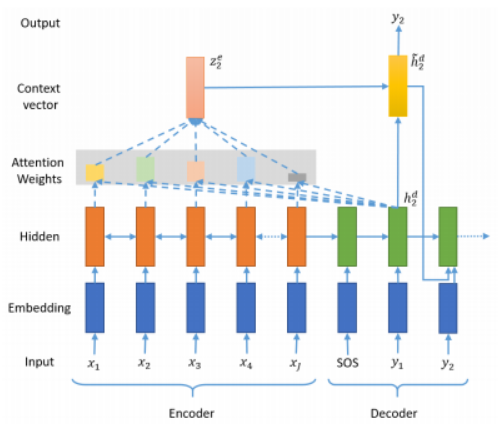

In [45]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [46]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [47]:
# 모델 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train],
                    y=decoder_target_train,
                    validation_data=(
                        [encoder_input_test, decoder_input_test],decoder_target_test),
                    batch_size=256,
                    callbacks=[es],
                    epochs=50)

Epoch 1/50
269/269 [==============================] - 429s 2s/step - loss: 6.3897 - val_loss: 5.6233
Epoch 2/50
269/269 [==============================] - 417s 2s/step - loss: 5.5425 - val_loss: 5.2156
Epoch 3/50
269/269 [==============================] - 417s 2s/step - loss: 5.1615 - val_loss: 4.9817
Epoch 4/50
269/269 [==============================] - 417s 2s/step - loss: 4.8722 - val_loss: 4.7567
Epoch 5/50
269/269 [==============================] - 417s 2s/step - loss: 4.6342 - val_loss: 4.6025
Epoch 6/50
269/269 [==============================] - 417s 2s/step - loss: 4.4200 - val_loss: 4.4563
Epoch 7/50
269/269 [==============================] - 417s 2s/step - loss: 4.2457 - val_loss: 4.3647
Epoch 8/50
269/269 [==============================] - 417s 2s/step - loss: 4.0940 - val_loss: 4.2690
Epoch 9/50
269/269 [==============================] - 417s 2s/step - loss: 3.9558 - val_loss: 4.2016
Epoch 10/50
269/269 [==============================] - 417s 2s/step - loss: 3.8375 - val_lo

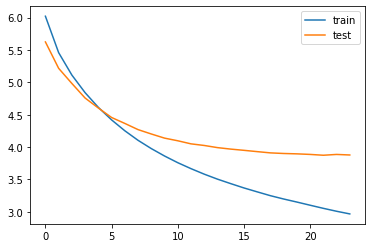

In [48]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [49]:
# 6. 모델 저장하기
from keras.models import load_model
model.save('attention_seq2seq.h5')

### 4. 인퍼런스 모델 구현

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로
복원해야하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [52]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 A집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

***seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다***

훈련 단계
- 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.

인퍼런스 단계
- 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [53]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

In [54]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [55]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

#### 모델 테스트

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.


In [56]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

<a name="result"></a>
### 4. 실제 결과와 요약문 비교하기 (추상적 요약)
---

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교한다.

In [60]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 Headline :", seq2summary(decoder_input_test[i]))
    print("예측 Headline :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : expressing condolence death people fire mumbai kamala mills compound prime minister narendra modi friday tweeted thoughts families hour grief president ram nath kovind tweeted wishing injured early recovery efforts fire fighters rescue 
실제 Headline : pm modi offers condolences to kin of mumbai fire victims 
예측 Headline :  pm modi condoles death of ram mandir in gujarat


원문 : cpi general secretary sitaram yechury tuesday alleged corruption black money terrorism post demonetisation six months still data much money old currency notes returned system said government let big fish bank loan defaulters ruined india informal economy added 
실제 Headline : corruption terrorism post note ban yechury 
예측 Headline :  pmo in corruption case against banks in pnb fraud case


원문 : scientists genome project write plan raise million funding artificial human dna plan write human genome scratch incorporate human cells received criticism medical scientists world meeting new york may discuss project fu

<a name="extrative"></a>
## 5. Summa을 이용해서 추출적 요약해보기
---

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높다. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다.

Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아본다.


1. text (str) : 요약할 테스트.
2. ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
3. words (int or None, optional) – 출력에 포함할 단어 수. 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
4. split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다.. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여본다. 원문의 0.005%만을 출력하도록 설정했다.

In [61]:
import requests
from summa.summarizer import summarize

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [73]:
for i in range(10):
    print("실제 HEADLINE : ", data['headlines'][i])
    print("추출적 요약 HEADLINE : ", summarize(data['text'][i], ratio=0.5))
    print("\n")

실제 HEADLINE :  upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 HEADLINE :  upGrad's Online Power Learning has powered 3 lakh+ careers.


실제 HEADLINE :  Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 HEADLINE :  Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


실제 HEADLINE :  New Zealand end Rohit Sharma-led India's 12-match winning streak
추출적 요약 HEADLINE :  The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


실제 HEADLINE :  Aegon life iTerm insurance plan helps customers save tax
추출적 요약 HEADLINE :  Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.


실제 HEADLINE :  Have known Hirani for yrs, what if MeToo claims are not true: Sonam
추출적 요약 HEADLINE :  Speaking about the sexual harassment a

<a name="summary"></a>
## 프로젝트 요약
---

**루브릭**
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.

   - Abstractive 모델의 올바른 입력값을 위해 텍스트를 전처리 해야했다. 먼저 중복, NULL 값이 존재하는 샘플을 제거하고     정규화 사전, 불용어 사전을 확인하여 생략/축약 표현, stopwords를 확인하고 preprocess_sentence 함수로 해당 표현을 클리닝하였다.     이외에도 시작토큰, 종료 토큰을 추가하고 데이터셋 분리, 정수인코딩 과정을 거쳐 모델에 맞는 input 데이터를 만들었다.
   
   
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.

    - EarlyStopping(monitor='val_loss', patience=2)로 설정하여 2번이상 val_loss가 낮아지지 않았을 때 모델 학습을 중단 시키는 테크닉을 배울 수 있었고 이 프로젝트의 경우 학습에 시간이 많이 걸렸기 때문에 조기종료 설정은 필수라는 생각이 들었다. Abstractive 모델의 예측 Headlines의 결과는 기대 이하였다. 아마 추가적으로 관련 컨텐츠를 학습한 추가적인 Embedding Layer를 전이 학습을 시켜보면 좋을 것 같다. 아래 케이스의 경우 원문에 나오지 않은 텍스트와 같은 단어가 의미 없이 여러번 반복되는 결과를 보여주었는데 전처리가 뭔가 잘못됐을 수도 있고 다른 문장에서도 실제 문장의 의미와 다른 예측 Headline을 제시해서 아직 해결해야 하는 문제가 많다는 것을 확인할 수 있었다.

```
원문 : social media platform twitter thursday introduced safety calendar features curb online harassment abuse includes suspending accounts violent groups along ban abusive hateful move comes week ceo jack dorsey admitted platform enough tackle trolls 
실제 Headline : twitter bans display names to fight abuse 
예측 Headline :  facebook launches content content content
```    

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.

    - Extractive 방식으로 추출된 요약문은 Abstractive 요약 결과에 비해 문법완성도, 핵심단어 포함 측면에서 괜찮은 요약을 보여주는 것 같다. 원문에 있는 문장을 추출하는 것이기 때문에 원문의 내용과 정확한 문법(순서)가 반영되었기 때문이라 생각한다.그리고 원문의 0.005%만을 출력하도록 설정하였을 때 실제 HEADLINE에 비해 길이가 길었는데 ratio를 어떻게 설정하느냐에 따라서 원문의 정보 추출 비율, 실제 headline과의 유사도관계를 확인해보는 실험도 의미가 있을 것 같다.

    


**후기**

뉴스의 헤드라인과 섬네일 이미지는 뉴스의 조회수에 상당히 많은 영향을 끼치는 요소이다. 아무리 원문에 좋은 내용이 담겨 있다 하더라도 매력적이지 않은 제목을 가지고 있다면 사용자들은 조금 더 자극적이고 한 눈에 눈길을 끄는 컨텐츠를 찾게 된다. 그만큼 뉴스 요약 문제는 단순히 한줄의 문장이 아니라 기자들의 전문성과 경험이 담겨 있는 작품이라고 생각한다. 추상적 요약, 추출적 요약 방법을 사용해 간단한 뉴스 요약 모델의 결과를 확인해봤는데 내 예상보다 좋은 성능을 보여주지는 못했다. 단순히 몇개의 클래스를 예측하는 문제가 아니라 다중 분류 문제에서도 상당히 많은 단어를 조합해서 결과를 제시해야 하기 때문에 상당히 어려운 NLP 문제인 것 같다. 추출적 요약 방법의 경우 빠르게 요약 결과를 확인해볼 수 있었고 원문과 내용, 문법적 측면에서 괜찮은 수준의 요약 결과를 보여주었다.